# Binary Source Experiments

In [7]:
import numpy as np
import emcee
import MulensModel as mm
import matplotlib.pyplot as plt
import sys

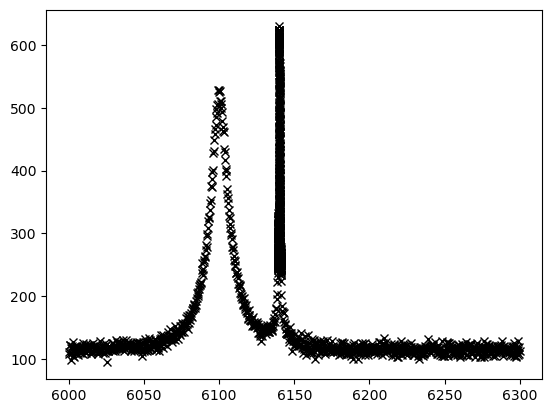

In [10]:
# First, prepare the data. There is nothing very exciting in this part,
# so you may skip it.
t_0_1 = 6100.
u_0_1 = 0.2
t_0_2 = 6140.
u_0_2 = 0.01
t_E = 25.
assumed_flux_1 = 100.
assumed_flux_2 = 5.
assumed_flux_blend = 10.
n_a = 1000
n_b = 600
time_a = np.linspace(6000., 6300., n_a)
time_b = np.linspace(6139., 6141., n_b)
time = np.sort(np.concatenate((time_a, time_b)))
model_1 = mm.Model({'t_0': t_0_1, 'u_0': u_0_1, 't_E': t_E})
A_1 = model_1.get_magnification(time)
model_2 = mm.Model({'t_0': t_0_2, 'u_0': u_0_2, 't_E': t_E})
A_2 = model_2.get_magnification(time)
flux = A_1 * assumed_flux_1 + A_2 * assumed_flux_2 + assumed_flux_blend
flux_err = 6. + 0. * time
flux += flux_err * np.random.normal(size=n_a+n_b)
my_dataset = mm.MulensData([time, flux, flux_err], phot_fmt='flux')
# If you want to plot, then just uncomment:
plt.plot(time, flux, 'kx')
plt.show()